<a href="https://colab.research.google.com/github/dpwalford/STA4032/blob/main/Math_24_Lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install wandb # installs all the nessary packages
!apt-get install poppler-utils
!pip install pdf2image
!pip install flashtorch
import requests
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from torchvision import *
from torchvision.models import *
import wandb as wb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def GPU(data): #makes python use the computerrs GPU for faster proccesing
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)

def plot(x): # creates a plot function for the datadeck
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

def get_google_slide(url): # creates a function to pull the data deck
    url_head = "https://docs.google.com/presentation/d/"
    url_body = url.split('/')[5]
    page_id = url.split('.')[-1]
    return url_head + url_body + "/export/pdf?id=" + url_body + "&pageid=" + page_id

def get_slides(url): # expands on the function to pull the data deck
    url = get_google_slide(url)
    r = requests.get(url, allow_redirects=True)
    open('file.pdf', 'wb').write(r.content)
    images = convert_from_path('file.pdf', 500)
    return images

def load(image, size=224): # makes the size of the images equal
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    tensor.requires_grad = True
    return tensor



In [ ]:
# loads alexnet
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

model = alexnet(weights='DEFAULT').to(device)
model.eval();

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 117MB/s]


In [ ]:
#import my datadeck (wearing glasses vs. not)
url = "https://docs.google.com/presentation/d/1oSd7LG-ac0X7oKcYP60eKfqrHo7iOdOKM249BtYyrDw/edit#slide=id.p"

In [ ]:
images = []

for image in get_slides(url):

    plot(image)

    images.append(load(image))

images = torch.vstack(images)

In [ ]:
images.shape

torch.Size([50, 3, 224, 224])

In [ ]:
model(images)

tensor([[-4.0410, -0.7207, -3.1051,  ..., -5.4743,  0.8080,  4.3100],
        [ 0.0610, -1.9994, -1.9961,  ..., -2.8625, -1.0642,  3.7680],
        [ 0.3474, -2.6225, -3.6890,  ..., -4.9869, -1.3464,  2.1135],
        ...,
        [ 3.0704, -0.6367, -3.0043,  ..., -3.4294,  0.3703,  4.5380],
        [ 1.5060, -3.1737, -3.3729,  ..., -2.9438,  0.6299,  4.2812],
        [ 1.3346, -4.3247, -2.9904,  ..., -2.3367,  1.3092,  1.5439]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
y = model(images)

In [ ]:
y.shape

torch.Size([50, 1000])

In [ ]:
# guesses
guesses = torch.argmax(y, 1).cpu().numpy()

In [ ]:
#prints the labels for the data feck of the guesses
for i in list(guesses):
    print(labels[i])

In [ ]:
Y = np.zeros(50,)
Y[25:] = 1

In [ ]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# Y = np.zeros(100,)
# Y[50:] = 1

In [ ]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
X = y.detach().cpu().numpy()

In [ ]:
X.shape

(50, 1000)

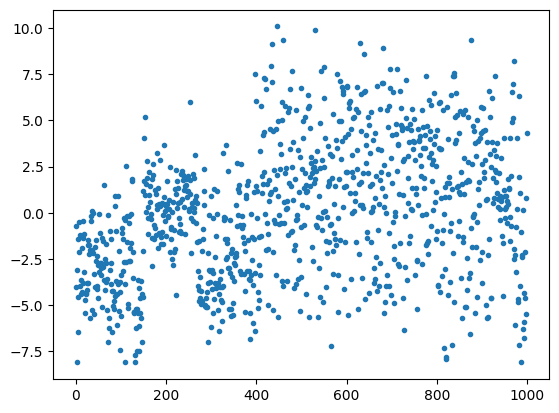

In [ ]:
plt.plot(X[0],'.')

(array([ 26.,  94., 143., 154., 189., 170., 107.,  68.,  41.,   8.]),
 array([-8.11276913, -6.29205084, -4.47133255, -2.65061426, -0.82989597,
         0.99082232,  2.8115406 ,  4.63225889,  6.45297718,  8.27369499,
        10.09441376]),
 <BarContainer object of 10 artists>)

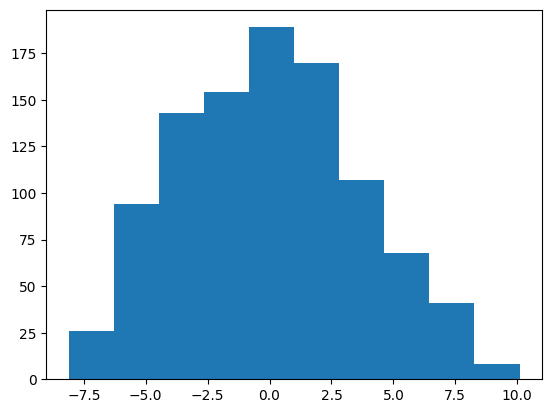

In [ ]:
plt.hist(X[0])

In [ ]:
X = GPU_data(X)
Y = GPU_data(Y)

In [ ]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [ ]:
def cross_entropy(outputs, labels):
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]

In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def Truncated_Normal(size):

    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2)
    u2 = torch.rand(size)
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2)

    return z

In [ ]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [ ]:
X.shape

torch.Size([50, 1000])

In [ ]:
def get_batch(mode):
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [ ]:
def model(x,w):

    return x@w[0]

In [ ]:
def make_plots():

    acc_train = acc(model(x,w),y)

    # xt,yt = get_batch('test')

    # acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train})

In [ ]:
wb.init(project="Linear_Model_Photo_1");
c = wb.config

c.h = 0.001
c.b = 32
c.epochs = 100000

w = [GPU(Truncated_Normal((1000,2)))]

optimizer = torch.optim.Adam(w, lr=c.h)

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wb.log({"loss": loss})

    make_plots()


<IPython.core.display.Javascript object>